In [1]:
from validphys.api import API
import matplotlib.pyplot as plt
import sys

# Add the path to the library folder
sys.path.append('./lib')

from utils import XGRID, build_fk_matrix, regularize_matrix
from model import PDFmodel
from gen_dicts import generate_dicts
from validphys.api import API

import numpy as np
import pandas as pd

Using Keras backend


# Utility functions for the null space

In [2]:
import scipy as sp
from typing import Any, Tuple
import numpy.typing as npt

def null_space_eig(eigvals: npt.ArrayLike, eigvecs: npt.NDArray[np.float64], tol: float = None) -> Tuple[npt.NDArray[np.float64],npt.NDArray[np.float64]]:
  """
  Compute the kernel and its orthogonal space given as set
  of eigenvalues and eigenvectors.

  The kernel space is constructed out of the eigenvectors whose eigenvalue
  is zero. The eigenvalues are compared to tolerance. If the value is greater
  than the tolerance, then it is considered non-zero.

  The tolerance is a parameter of this function. If `tol` is not provided,
  then it is defined as the product of the largest eigenvalue with the
  smallest precision number given the type the of the eigenvalues.

  Parameters
  ----------
  eigvals: array
    List of eigenvalues that are compared to the tolerance.
  eigvecs: NDArray
    Matrix where the second index select the i-th eigenvector relative
    to the i-th eigenvalue, and the first index runs over the components
    of each eigenvector.
  tol: float
    The tolerance for the zero-value veto.

  Return
  ------
  The two sets of basis vectors for the kernel and its orthogonal space. These
  are subspaces of the original eigenspace provided as an argument. The indexing
  follows the same as `eigvecs`.
  """
  if tol is None:
    tol = np.amax(eigvals, initial=0.) * np.finfo(eigvecs.dtype).eps
  num = np.sum(eigvals > tol, dtype=int) # Number of non-zero eigenvalues
  ker = eigvecs[:,num:]
  orth = eigvecs[:,:num]
  return ker, orth
  
def project_matrix(matrix, basis1, basis2=None):
  """
  Project the matrix into a given basis. If two bases are given,
  then the first basis specifies the projection of the matrix on
  the right space, while the second basis for the left space.

  In particular, the projection is computed as follows $\delta$

  ..math::

    M_{i_{B_1} j_{B_2}} = \sum_{i=1}^{dim(B_1)} \sum_{j=1}^{dim(B_2)}
    \mathbf{v}_{B_2}^{(j)T} \cdot M \cdot \mathbf{v}_{B_1}^{(i)}

  where :math:`\mathbf{v}_{B}^{(i)}` is the i-th vector of the basis B.

  If `basis2` is not provided, then basis2 is taken to be standard basis
  (i.e. the one specified by the identity matrix).

  Note that the matrix is not required to be squared.

  Parameters
  ----------
  matrix: NDArray
    The matrix that is projected.
  basis1: NDArray
    The (right) basis on which the matrix is projected.
  basis2: NDArray
    The (left) basis on which the matrix is projected.

  Returns
  -------
  The projection of the matrix into the bases `basis1` and, if 
  given `basis2`.
  """
  if basis2 is None:
    basis2 = np.eye(matrix.shape[0])

  emb_space1 = basis1.shape[0] # Embedding space base 1
  emb_space2 = basis2.shape[0] # Embedding space base 2

  # Check if the bases are compatible with the matrix
  if matrix.shape[0] != emb_space2 or matrix.shape[1] != emb_space1:
    raise ValueError ('The matrix cannot be projected into the two bases.')

  M_orth = basis2.T @ matrix @ basis1

  return M_orth

def project_vector(vector, basis):
  """
  Project a vector into a given basis.
  """
  basis_dim = basis.shape[1]
  space_dim = basis.shape[0]
  if space_dim != vector.shape[0]:
    raise ValueError ('The matrix cannot be projected into the basis')
  
  res = [np.dot(vector, basis[:,i]) for i in range(basis_dim)]
  return res

In [3]:
seed = 14132124

In [4]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=708,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [5]:
# Retrieve data from NNPDF
groups_data = API.procs_data(**common_dict)
tuple_of_dicts = generate_dicts(groups_data)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data
FK = build_fk_matrix(fk_table_dict)

In [6]:
C = API.groups_covmat_no_table(**common_dict)

# Serialize covmat
C_index = C.index
C_col = C.columns
Cinv = pd.DataFrame(np.linalg.inv(C), index=C_index, columns=C_col)

# Diagonalize covariance matrix
eigvals_Cinv, R_Y = np.linalg.eigh(Cinv)
if eigvals_Cinv[-1] > eigvals_Cinv[0]:
    eigvals_Cinv = eigvals_Cinv[::-1]
    R_Y = R_Y[:,::-1]
D_Y = np.zeros_like(R_Y)
np.fill_diagonal(D_Y, eigvals_Cinv)

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


In [26]:
# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    # (group, experiment, index)
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError

In [27]:
nnpdf_model = PDFmodel(input=XGRID,
                       outputs=9,
                       architecture=[28,20],
                       activations=['tanh', 'tanh'],
                       kernel_initializer='RandomNormal',
                       user_ki_args={'mean': 0.0, 'stddev': 1.0},
                       seed=seed,
                       dtype='float64')
NTK = nnpdf_model.compute_ntk()

# Flatten NTK
prod = 1
oldshape = NTK.shape
for k in oldshape[2:]:
    prod *= k
NTK_flat = np.array(NTK).reshape(prod,-1)

# Compute predictions at initialization
f0 = nnpdf_model.predict(squeeze=True)

Load data from GD training

In [ ]:
import pickle
with open('training.pkl', 'rb') as file:
    results = pickle.load(file)

pred_in_time = results[1]
pdfs_in_time = results[2]
learning_rate_gd = 0.00000001

# Computing matrices from notes
-------------------------------

In [89]:
def regularize_matrix_svd(M, hermitean: bool = False, tol: float = None):
   """
   Regularization of a matrix wither with svd or evd depending
   on whether the matrix is symmetric or not.

   Description
   -----------
   When dealing with numerical precision issues in matrices (e.g. symmetric 
   matrices with eigenvalues spanning a very large range) regularization turns
   out to be essential. If the matrix is symmetric, the regularization is applied
   to the eigenvalues; if the matrix is not symmetric, the regularization is
   applied to the singular values. The tolerance, which defines the smallest
   distinguishable difference, is eps * max(s) where eps is the machine epsilon
   (~2.2e-16 for float64) and max(s) is the highest eigenvalue or the highest
   singular value.

   Parameters
   ----------
   M: np.ndarray
    The matrix that needs to be regularized. The matrix must be squared.
   tol: float
    The tolerance that defines the smallest distinguishable value. Default is None,
    and the tolerance is defined as eps * max(s).

   Returns
   -------
   If the matrix is symmetric, it returns the regularized matrix and a tuple
   containing the regularized eigenvalues in first position and the respective
   eigenvectors in second position. If the matrix is not symmetric, it returns
   the regularized matrix, and a tuple (U, S_reg, Vh).
   """
   U, S, Vh = np.linalg.svd(M, full_matrices=True, hermitian=hermitean)
   if tol is None:
     tol = np.amax(S, initial=0.) * np.finfo(M.dtype).eps
   reg_S = np.where(S > tol, S, 0.0)
   M_reg = np.dot(U * reg_S, Vh)
      
   return M_reg, (reg_S, Vh, U, tol)

Regularize $(FK)$

In [734]:
FK_reg, (S_FK, Vh_FK, _, tol) = regularize_matrix_svd(FK, tol=1e-10)

# $M = (FK)^T C_Y^{-1} (FK) = RDR^T$
Here I compute the matrix $M$ as defined above. Then I check that the SVD gives the same result as the eigen decomposition/

In [92]:
M = FK.T @ Cinv.to_numpy() @ FK
U_M, S_M, Vh_M = np.linalg.svd(M, full_matrices=True, hermitian=True)
V_M = Vh_M.T
assert(np.allclose(M, M.T))

In [93]:
eigvals_M, eigvecs_M = np.linalg.eigh(M)
eigvals_M = eigvals_M[::-1]
eigvecs_M = eigvecs_M[:, ::-1]

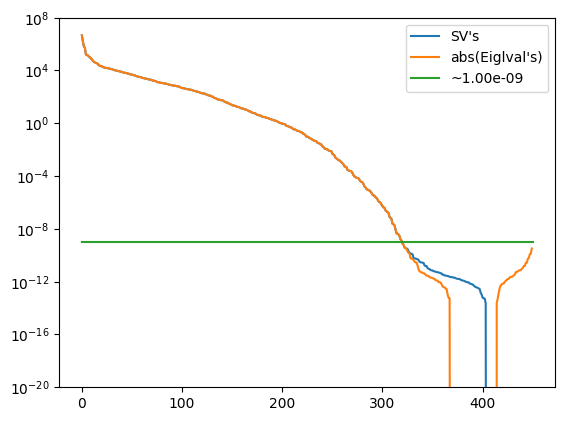

In [94]:
eps = np.finfo(M.dtype).eps
y_line = eps * S_M[0]

plt.plot(S_M, label="SV's")
plt.plot(np.abs(eigvals_M), label="abs(Eiglval's)")
plt.plot(np.linspace(0,450,100), [y_line for _ in range(100)], label=f'~{y_line:.2e}')
#plt.xscale('log')
plt.yscale('log')
plt.ylim([1.e-20,1.e8])
plt.legend()

Singular values and eigenvalues depart from each other at $\epsilon \times \textrm{max}(SVD_M)$

In [125]:
eps * S_M[0]

9.996364814535864e-10

In [211]:
M_reg, (S_M_reg, Vh_M, U_M, tol) = regularize_matrix_svd(M + 1e-6 * np.eye(M.shape[0]), tol=eps * S_M[0], hermitean=True)

In [212]:
M_pinv = np.linalg.pinv(M_reg, rcond=eps)

In [213]:
S_M_reg_dag = [1/val if val != 0.0 else 0.0 for val in S_M_reg]

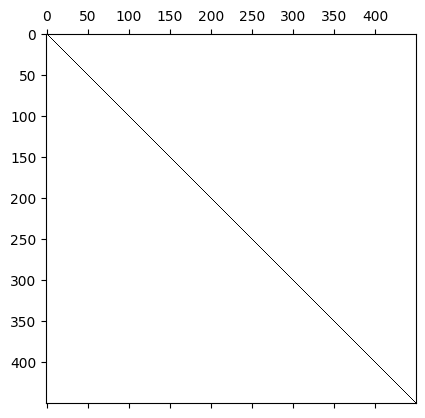

In [214]:
S_M_mat = np.zeros_like(U_M)
S_M_dag_mat = np.zeros_like(U_M)
np.fill_diagonal(S_M_mat, S_M_reg)
np.fill_diagonal(S_M_dag_mat, S_M_reg_dag)
plt.spy(S_M_dag_mat @ S_M_mat)

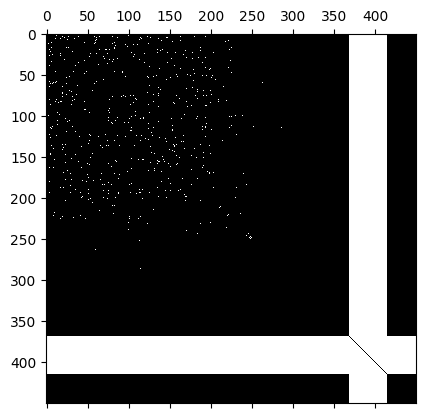

In [215]:
Lambda = U_M.T @ U_M
np.allclose(Lambda, np.eye(Lambda.shape[0]))
plt.spy(Lambda)
#np.fill_diagonal(Lambda, 0)

In [216]:
M_my_inv = Vh_M.T @ S_M_dag_mat @ U_M.T

In [217]:
test = Vh_M.T @ S_M_dag_mat @ U_M.T @ U_M @ S_M_mat @ Vh_M

Text(0.5, 1.0, '$M^{\\dag}$ as computed in numpy')

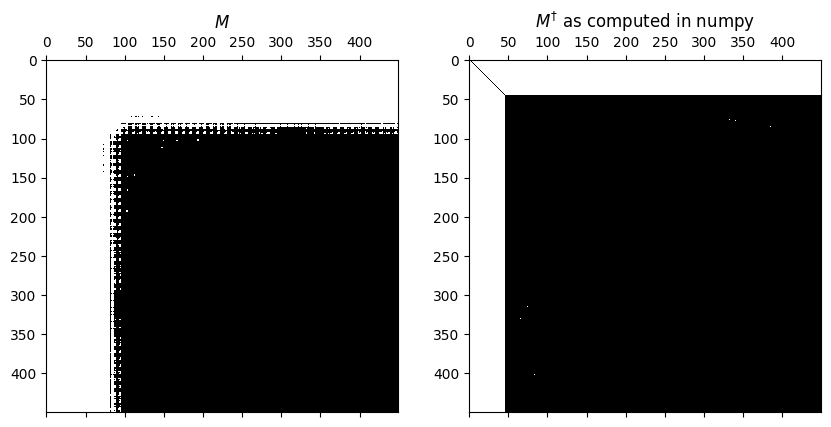

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # Adjust figure size for better visibility
axs[0].spy(M, precision=eps*S_M_reg[0]) 
axs[0].set_title(r'$M$')
axs[1].spy(M_pinv, precision=eps*S_M_reg[0])
axs[1].set_title(r'$M^{\dag}$ as computed in numpy')


Text(0.5, 1.0, '$M^{\\dag}$ homemade')

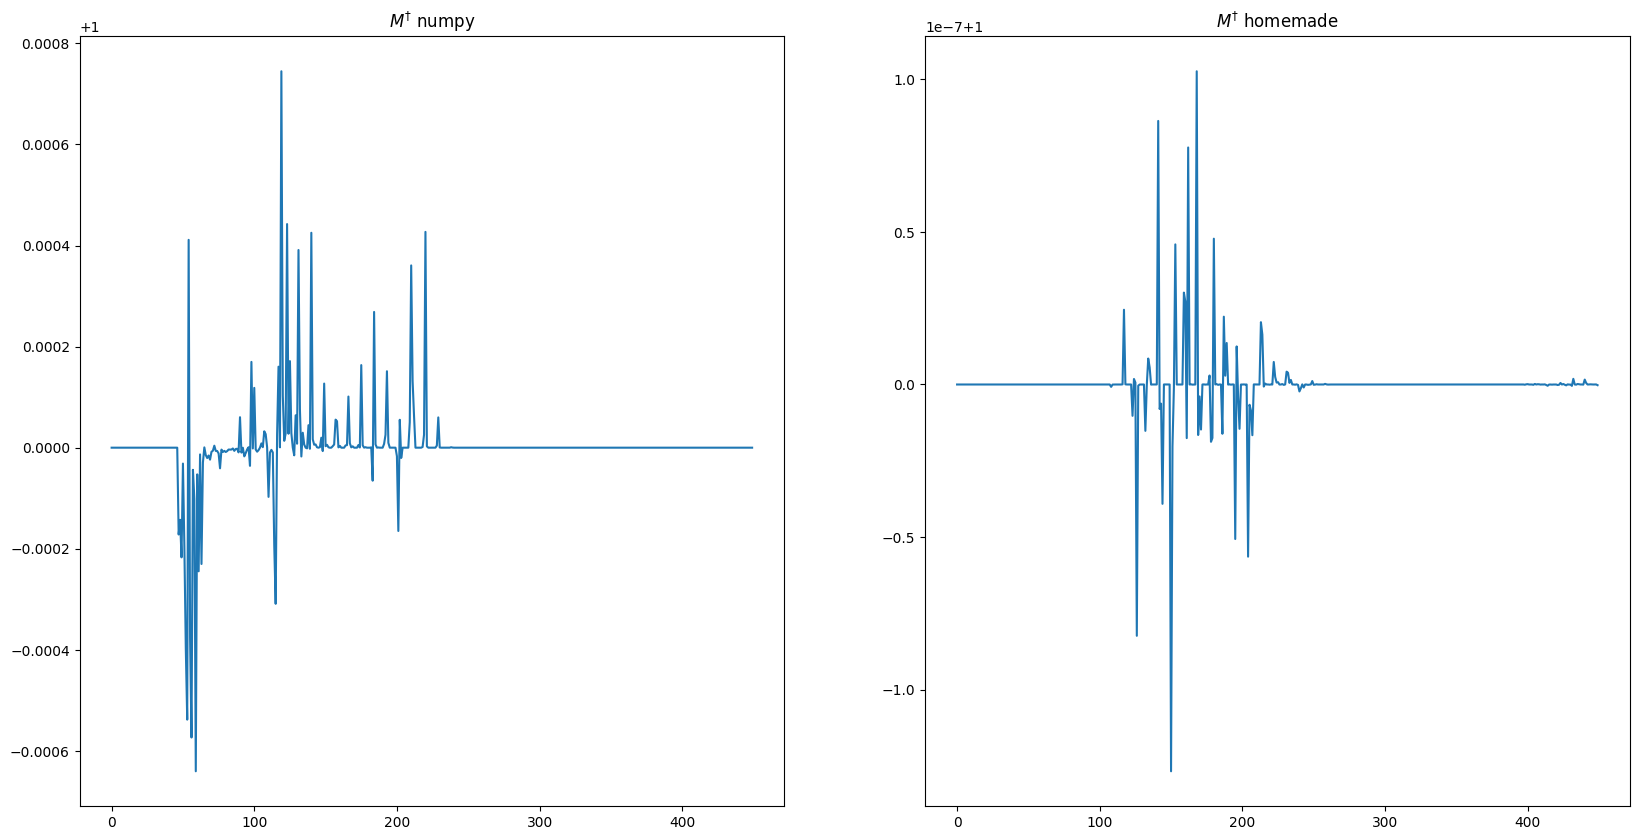

In [219]:
M_at_M_pinv = M_pinv@M_reg
M_at_M_my_pinv = M_my_inv@M_reg

fig, axs = plt.subplots(1, 2, figsize=(20, 10))  # Adjust figure size for better visibility
axs[0].plot(M_at_M_pinv.diagonal())
axs[0].set_title(r'$M^{\dag}$ numpy')
axs[1].plot(M_at_M_my_pinv.diagonal())
axs[1].set_title(r'$M^{\dag}$ homemade')


In [ ]:
first_zero_M = np.argwhere(S_M_reg == 0.0)[0][0] - 150
print(S_M_reg[first_zero_M])
print(S_M_reg[first_zero_M-1])
M_orth = V_M[:,:first_zero_M].T @ M_reg @ V_M[:,:first_zero_M]
M_ker = V_M[:,first_zero_M:].T @ M_reg @ V_M[:,first_zero_M:]

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # Adjust figure size for better visibility
axs[0].spy(M_ker, precision=eps*S_M_reg[0]) 
axs[0].set_title(r'$M_{ker}$')
axs[1].spy(M_orth, precision=eps*S_M_reg[0])
axs[1].set_title(r'$M_{\bot}$')

In [ ]:
np.linalg.cond(M_orth)

In [671]:
U_Mp, S_Mp, Vh_Mp = np.linalg.svd(M_orth, hermitian=True)

In [ ]:
M_orth_inv = np.linalg.inv(M_orth)
test = M_orth_inv@M_orth
plt.matshow(test)

# $\tilde{H} = D^{1/2} R^T \Theta R D^{1/2}$

In [ ]:
D = np.zeros_like(eigvecs_M)
np.fill_diagonal(D, S_M_reg)
ntk, (eigvals_ntk, R_ntk) = regularize_matrix(NTK_flat)
H_tilde = np.sqrt(D) @ eigvecs_M.T @ ntk @ eigvecs_M @ np.sqrt(D)

# Check if symmetric
print(f'Is symmetric: {np.allclose(H_tilde, H_tilde.T)}')

In [ ]:
U_ht, S_ht, Vh_ht = np.linalg.svd(H_tilde, full_matrices=False, hermitian=True)
eigvals_Ht, eigvecs_Ht = np.linalg.eigh(H_tilde)
eigvals_Ht = eigvals_Ht[::-1]
eigvecs_Ht = eigvecs_Ht[:, ::-1]
plt.plot(S_ht, label='SVD')
plt.plot(np.abs(eigvals_Ht), label='abs(Eigvals)')
yline = eps*S_ht[0]
plt.plot(np.linspace(0,450,100), [yline for _ in range(100)], label=f"{yline:.2e}")
plt.yscale('log')
plt.legend()
#plt.xscale('log')

As we see above, the singular values match the eigenvalues up to some threshold, which is the smallest resolution given by float64 precision. We can regularise $\tilde{H}$ using that tolerance.

In [358]:
H_tilde, (S_ht, Vh_ht, _) = regularize_matrix_svd(H_tilde, tol=eps*S_ht[0])
V_ht = Vh_ht.T

We can then visualise $\tilde{H}$ as a sparse matrix

In [ ]:
# Create the plot
plt.figure(figsize=(10, 10))  # Adjust figure size for better visibility
# Plot using spy()
plt.figure(figsize=(8, 8))
plt.spy(H_tilde, precision=eps*S_ht[0])  # Adjust markersize for better visibility

# Title and display
plt.title(r"Visualization of $\tilde{H}$")
plt.show()


In [ ]:
first_zero_ht = np.argwhere(S_ht == 0.0)[0][0]
print(S_ht[first_zero_ht])
print(S_ht[first_zero_ht-1])
H_tilde_orth = V_ht[:,:first_zero_ht].T @ H_tilde @ V_ht[:,:first_zero_ht]
H_tilde_ker = V_ht[:,first_zero_ht:].T @ H_tilde @ V_ht[:,first_zero_ht:]

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(10, 10))  # Adjust figure size for better visibility
axs[0].spy(H_tilde_ker, precision=eps*S_ht[0]) 
axs[0].set_title(r'$\tilde{H}_{ker}$')
axs[1].spy(H_tilde_orth, precision=eps*S_ht[0])
axs[1].set_title(r'$\tilde{H}_{\bot}$')


In [ ]:
H_tilde_inv = np.linalg.inv(H_tilde_orth)
test = H_tilde_orth @ H_tilde_inv
plt.matshow(test)

In [ ]:
np.linalg.cond(H_tilde_orth)

# Null space of $M$ and $\tilde{H}$

We expect $M$ and $\tilde{H}$ to have different kernels as $\tilde{H}$ contains the NTK. We can plot the singular values after regularisation:

In [ ]:
plt.plot(S_ht, label=r"$\tilde{H}$")
plt.plot(S_M, label=r'$M$')
plt.legend()
plt.yscale('log')
plt.xscale('log')

The singular values of $\tilde{H}$ go to zero before those of $M$. This means that 
$$
\textrm{dim} \left( \textrm{Ker} (\tilde{H}) \right) > \textrm{dim} \left( \textrm{Ker} (\tilde{M}) \right)  \,.
$$
How do they overlap?

# $\tilde{H_{\epsilon}} = D_Y^{1/2} R_Y^T (FK) \Theta (FK)^T R_Y D_Y^{1/2}$

In [ ]:
H_eps_tilde = np.sqrt(D_Y) @ R_Y.T @ FK_reg @ ntk @ FK_reg.T @ R_Y @ np.sqrt(D_Y)
#H_eps_tilde, (eigvals_H_eps_tilde, eigvecs_H_eps_tilde) = regularize_matrix(H_eps_tilde, tol=tol)

# Check if symmetric
print(f'Is symmetric: {np.allclose(H_eps_tilde, H_eps_tilde.T)}')

# $b = \Theta (FK)^T C_Y^{-1} y \hspace{5mm} \textrm{and} \hspace{5mm} \tilde{b} = D^{1/2} R^T b$

In [399]:
b = ntk @ FK.T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy('float64')
b_tilde = np.sqrt(D) @ eigvecs_M.T @ b

# Calculation of $f_{\infty}$, $\varepsilon_{\infty}$ and evolution
We now compute the limiting solution $f_{\infty}$, which is the value that minimizes the loss function.
$$
f_{\infty} = \mathbf{M}_{\bot\bot}^{-1} (FK)_{\bot}^T C_Y^{-1} y \,.
$$
We also compute
$$
\varepsilon_{\infty} = y - (FK)_{\bot}f_{\infty} = \biggl(1 - (FK)_{\bot} \mathbf{M}_{\bot\bot}^{-1} (FK)_{\bot}^T C_Y^{-1}\biggr) y\,,
$$
together with the minimum of the loss-function
$$
\mathcal{L}^{*} = \frac{1}{2} y^T C_Y^{-1} \varepsilon_{\infty}

In [425]:
f_inf = M_orth_inv @ FK.T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy(dtype='float64')[:,0]
eps_inf = Y.to_numpy(dtype='float64')[:,0] - FK @ f_inf
L_inf = 0.5 * Y.to_numpy(dtype='float64')[:,0].T @ Cinv.to_numpy(dtype='float64') @ eps_inf

We also compute the following quantity, which will be useful the description of the evolution
$$
\begin{align}
& \tilde{\varepsilon}_{\infty} = D_{Y}^{1/2} \, R_Y^T \varepsilon_{\infty} \hspace{5mm} \textrm{where} \hspace{5mm} C_Y^{-1} = R_Y D_Y R_Y^T \\
\end{align}
$$

In [430]:
eps_inf_tilde = np.sqrt(D_Y) @ R_Y.T @ eps_inf

# Check eq.(67)
First we verify that
$$
   (FK)^T C_Y^{-1} (FK)_{\bot} M_{\bot\bot}^{-1} = 1 \,.
$$
Note that the right-most $(FK)$ is the full matrix, while $(FK)_{\bot}$ is the one projected into the orthogonal space. To make things compatible, we need to use the same set of bases for both. If we don't do the same, we get:

In [431]:
test = FK.T @ Cinv.to_numpy(dtype='float64') @ FK @ M_dag

In [ ]:
plt.matshow(test)
plt.colorbar()

We can then check
$$
(FK)^T C_Y^{-1} - (FK)^T C_Y^{-1} (FK)_{\bot} M_{\bot\bot}^{-1} (FK)_{\bot}^T C_Y^{-1} = 0
$$

In [ ]:
first_bit = FK.T @ Cinv.to_numpy(dtype='float64')
second_bit = FK.T @ Cinv.to_numpy(dtype='float64') @ FK @ M_dag @ FK.T @ Cinv.to_numpy(dtype='float64')
test67 = second_bit - first_bit
np.allclose(np.zeros_like(test67), test67)

In [ ]:
test67.min()

We now check eq.(67) of the paper, that is
$$
\tilde{H}_{\varepsilon} \, \tilde{\varepsilon}_{\infty} = 0
$$

In [444]:
res = H_eps_tilde @ eps_inf_tilde

In [ ]:
res.min()